In [1]:
# from ..tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image

Total dataset size:
n_samples: 4324
n_features: 2914
n_classes: 158
X.shape:  (4324, 2914)


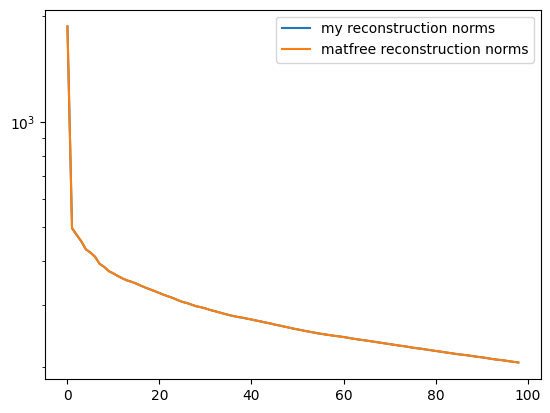

In [2]:
from sklearn.datasets import fetch_lfw_people
import sys

sys.path.append("..")
from tests import test_bidiag_JVP_and_VJP_jax as bidiag_module


lfw_people = fetch_lfw_people(min_faces_per_person=10)


# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


print("X.shape: ", X.shape)


def matvec(v, mat):
    return mat @ v


# X = np.random.randn(10, 10)

start_vec = X[0, :]
start_vec = jax.random.normal(key=jax.random.PRNGKey(1), shape=X[0, :].shape)

import matfree
from matfree.decomp import bidiag as bidiag_matfree

matves = 100

result = bidiag_matfree(matves, materialize=True)(matvec, start_vec, X)
mL, mR = result.Q_tall
mB = result.J_small

bidiag_output = bidiag_module.bidiagonalize_vjpable_matvec(
    num_matvecs=matves, custom_vjp=True, reorthogonalize=True
)(matvec, start_vec, jnp.asarray(X))
L = bidiag_output.ls
B = jnp.diag(bidiag_output.alphas) + jnp.diag(bidiag_output.betas, 1)
R = bidiag_output.rs

norms = [
    np.linalg.norm(X - (L[:, :i] @ B[:i, :i] @ R[:, :i].T)) for i in range(1, matves, 1)
]
m_norms = [
    np.linalg.norm(X - (mL[:, :i] @ mB[:i, :i] @ mR[:, :i].T))
    for i in range(1, matves, 1)
]
plt.plot(norms, label="my reconstruction norms")
plt.plot(m_norms, label="matfree reconstruction norms")
plt.yscale("log")
plt.legend()
plt.show()

# print(h, w)

# for i in range(8):
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow((mL @ mB @ mR.T)[i, :].reshape(h, w))
#     ax[1].imshow(X[i].reshape(h, w))
#     plt.show()

# for i in range(8):
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(mR[:, i].reshape(h, w))
#     # ax[1].imshow(X[i].reshape(h, w))
#     plt.show()